**Document scanner with image enhancement and compression**

**Mount Google Drive**


In [ ]:
"""from google.colab import drive
from pathlib import Path
drive.mount("/content/gdrive", force_remount=True)    #mounting gdrive folder"""

**Import Library**

In [ ]:
#%load_ext autoreload
#%autoreload 2
import glob
from PIL import Image
import sys
import cv2
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
cv_img=[]
image = cv2.imread("test pics/test_image.jpeg")
plt.imshow(image, cmap = 'gray')

# Automatic recognition of the document from the image 


Technique Used:

    1) Blur the image slightly so the contents written over it fades away
    2) Apply thresholding to separate the paper from background
    3) Perform morphological operations to get rid of extra/tiny areas falsely detected
    4) Find the possible closed contours in the thresholded image
    5) Approximate the contours to polygons and separate the ones which have 4 sides (since documents are usually considered to be paper with 4 sides)
    6) Find the area of all contours approximated with 4 sides
    7) Select the polygon with largest contour area to be the document area

In [ ]:
"""#import test image

import cv2
import matplotlib.pyplot as plt
import numpy as np

image = cv2.imread("test.jpeg")
plt.imshow(image, cmap = 'gray')"""

In [ ]:
#blurring and thresholding
blur = cv2.GaussianBlur(image, (3,3), 0)
hls = cv2.cvtColor(blur, cv2.COLOR_BGR2HLS)
low = np.array([0, 70, 0])
high = np.array([255, 255, 85])
thresh = cv2.inRange(hls, low, high)
plt.imshow(thresh, cmap = 'gray')

In [ ]:
# morphological closing and opening operation
kclose = np.ones((2,2), dtype=np.uint8)
kopen = np.ones((5,5), dtype=np.uint8)
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kclose, iterations=2)
opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kopen, iterations=6)
plt.imshow(opening, cmap = 'gray')

In [ ]:
#check the convex hull of the thresolded image 
from skimage.morphology import convex_hull_image
chull = convex_hull_image(opening)
plt.imshow(chull, cmap = 'gray')

In [ ]:
#find all contours in the image
contours, _ = cv2.findContours(opening, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

In [ ]:
#show all contours detected in the image
cnt_image = image
for cnt in contours:
    approx = cv2.approxPolyDP(cnt, 0.04*cv2.arcLength(cnt,True), True)
    cv2.drawContours(cnt_image, [approx], 0, (0,0,0), 5)
    x = approx.ravel()[0]
    y = approx.ravel()[1]
    #print (len(approx))
#     if len(approx) == 4:
#         cv2.drawContours(image, [approx], 0, (0,0,0), 5)
#         cv2.putText(image, "Quad", (x,y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0,0,0))
#         print(approx)
        #cnt_area.append()
plt.imshow(cnt_image, cmap = 'gray')
        

In [ ]:
#find the 4-sided polygon with maximum area
max_cnt_area = 0
max_cnt = []
for cnt in contours:
    approx = cv2.approxPolyDP(cnt, 0.03*cv2.arcLength(cnt,True), True)
    if len(approx) == 4:
        cnt_area = cv2.contourArea(cnt)
        if cnt_area > max_cnt_area:
            max_cnt_area = cnt_area
            max_cnt = approx

In [ ]:
#coordinates of selected polygon
max_cnt

# Warp the recognised document area to rectangular shape


Technique Used:

    1) Find approximate height and width of the area recognised
    2) Map the corner coordinates of selected polygon to the resized image
    3) Warp the polygon to resized image

In [ ]:
#find height and width of recognised document area

x = max_cnt[:,:,0].ravel()
y = max_cnt[:,:,1].ravel()
# print(x)
# print(y)
p1 = min(x)
p2 = max(x)
q1 = min(y)
q2 = max(y)
cx = (p1+p2)/2
cy = (q1+q2)/2
w = p2-p1
h=q2-q1

In [ ]:
#Map corner coordinates of resized image with height and width
if x[0] > x[1]:
    x1 = w
    x2 = 0
    x3 = 0
    x4 = w
    y1 = 0
    y2 = 0
    y3 = h
    y4 = h
else:
    x1 = 0
    x2 = 0
    x3 = w
    x4 = w
    y1 = 0
    y2 = h
    y3 = h
    y4 = 0

In [ ]:
#Source image corner coordinates
pts1 = np.float32(max_cnt)

In [ ]:
#pts1 = np.float32([[1098,61] ,[ 142  , 98], [ 133, 1499],[1173 ,1530]])

In [ ]:
##destination image corner coordinates
width = w
height = h
pts2 = np.float32([[x1,y1],[x2,y2],[x3,y3],[x4,y4]])

In [ ]:
#Perspective transform: deform the pixel grid and map this deformed grid to the destination image
matrix = cv2.getPerspectiveTransform(pts1, pts2)

In [ ]:
#fit the size of the image to the size of the given image 
imgOut = cv2.warpPerspective(image,matrix,(width,height))

In [ ]:
#perspective transformed and warped image
plt.imshow(imgOut, cmap = 'gray')

In [ ]:
#save the transformed image to current directory

cv2.imwrite("test pics/transform_img.jpg",imgOut)

### Image enhancement(magic filter)

In [ ]:
img1= cv2.imread("test pics/TEST1.jpeg")       # reading image
k=Image.fromarray(img1)
k

implementing moving average expression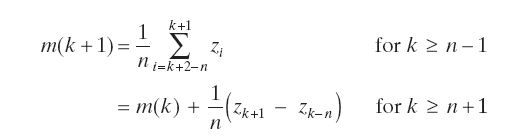


In [ ]:
               
gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
w,h=gray.shape
n=50
b=0.965            #hyperparameter
gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)         # converting to grayscale 
m=[]
lst=[]
m.append(gray[0,0]/n)        #initialize m
c=0
for i in range(0,w):
    for j in range(0,h):      #traversing each pixel
        if(j-n>0):
            m.append(sum(gray[i,j-n:j])/n)         #moving average
        else:
            prev=m[-1]
            m.append(prev+(1/n)*(gray[i,j]))        #moving average for boundry neighbour pixel 
        if(j==h-1):
            m.pop(0)
            lst.append(m)       #appending current average
            m=[]             #empty list for next iteration
            if(i+1<w):
                m.append(gray[i+1,0]/n)  
arr_moving_avg=np.array(lst)


g(x,y)=1   if f(x,y)>b*m(x,y)

> 




g(x,y)=0   if f(x,y)<b*m(x,y)

In [ ]:
import PIL
a,b=gray.shape
im3 = PIL.Image.new(mode="RGB", size=(b,a))        #dummy image
b=0.965
for i in range(w):
    for j in range(h):
        if(gray[i,j]>b*arr_moving_avg[i,j]):           #binarizing image based on moving average values
            im3.putpixel((j,i),(254,254,254))           #white
        else:
            im3.putpixel((j,i),(0,0,0))              #black
im3

In [ ]:
from PIL import Image
im1=im3.save("test pics/f3.jpg")

# Compression to given size

We can easily resize an image to given no. of pixels by interpolating the pixels.
But there is absolutely no way to estimate the size of the resized image after compression standards (such .jped or .png) applied over it.
This is because the compression factor depends upon what is exactly stored in the image.

So, the below technique uses iterative method to downscale the image upto the maximum size provided with some permissible error in size.

In [ ]:
#reduce image size below the maximum size of the file provided
def resize_image(path, max_file_size: int = 2 ** 20):

    image = cv2.imread(path)
    height, width = image.shape[:2]

    org_mem = os.stat(path).st_size
    org_bytes = org_mem / np.product(image.shape[:2])

    new_bytes = org_bytes * (max_file_size / org_mem)
    new_ratio = np.sqrt(new_bytes / org_bytes)
    new_width, new_height = int(new_ratio * width), int(new_ratio * height)

    new_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR_EXACT)
    return new_image

In [ ]:
import os

#output image
image_location = "test pics/TEST1.jpeg"

delta = 0.01 #permissible error allowed in final image size
max_file_size = 500000 #given size of final image
max_deviation_percentage = delta

current_memory = new_memory = os.stat(image_location).st_size
ratio = 1


#compare new and old memory sizes untill the error reaches within delta limit
while abs(1 - max_file_size / new_memory) > max_deviation_percentage:
    #resize image
    new_image = resize_image(image_location, max_file_size=max_file_size * ratio)
    cv2.imwrite(f"{image_location}", new_image)
    
    new_memory = os.stat(f"{image_location}").st_size
    ratio *= max_file_size / new_memory

In [ ]:
plt.imshow(new_image, cmap = 'gray')

# Save the converted images as pdf

In [ ]:
# Images from this folder are converted to pdf
img_list = [x for x in os.listdir('New folder')] 
# add new pages with the image 

for img in img_list:
    temp = cv2.imread(img)
    (w,h,c) = temp.shape
    ratio = w/h
    temp = cv2.resize(temp, (500, int(w/ratio)), interpolation=cv2.INTER_LINEAR_EXACT)
    cv2.imwrite(img, temp)
    print(ratio)


In [ ]:
from fpdf import FPDF
import os

pdf = FPDF()
pdf.set_auto_page_break(0)

img_list = [x for x in os.listdir('New folder')] 
# add new pages with the image 
for img in img_list:
    pdf.add_page()
    pdf.image(img)
# save the output file
pdf.output("Images1.pdf")


## motion deblurring using wiener filtring

In [ ]:
n= cv2.imread("test pics/motion_blur1.jpeg",0)         #loading image
Image.fromarray(n)

Implementing degradation function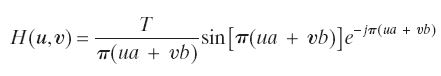

In [ ]:
import math
def degradation_function(u,v,a,b):               #degration function
  pi=3.14
  T=1
  div=pi*(u*a+v*b)
  mul1=T/div
  mul2=math.sin(div)*complex(math.cos(div),-1*math.sin(div))       
  H=mul1*mul2
  return H

implementing wiener filter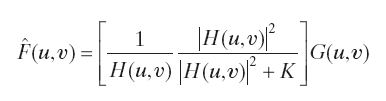

In [ ]:
s=n.shape        #image shape
new_real=[]
new_img=[]
a=0.999
b=0.999               #hyper parameters
m=10
dft=cv2.dft(np.float32(n),flags=cv2.DFT_COMPLEX_OUTPUT)                    #dft of image
fshift = np.fft.fftshift(dft)                                 #center shifting
for i in range(s[0]):
  for j in range(s[1]):              #traversing each image pixel
    if(i==0 and j==0):
      k=0
      new_real.append(k)          #preventing division by zero 
      new_img.append(k)
      continue
    h=abs(degradation_function(i,j,a,b))**2              #implementing wiener filter
    re=degradation_function(i,j,a,b).real
    im=degradation_function(i,j,a,b).imag
    re_shift=fshift[i,j,0]
    im_shift=fshift[i,j,1]
    
    mul=complex(fshift[i,j,0],fshift[i,j,1])/complex(re,im)     #inverse filtering
    multiplication=(h/(h+m))*mul                       
    new_real.append(multiplication.real)
    new_img.append(multiplication.imag)
Y_real=np.array(new_real).reshape(s[0],s[1])
Y_img=np.array(new_img).reshape(s[0],s[1])
Y=np.dstack((Y_real,Y_img))
f_ishift=np.fft.ifftshift(Y)              #inverse of center shifting
img_back=cv2.idft(f_ishift)              #idft
img_back1=cv2.magnitude(img_back[:,:,0],img_back[:,:,1])         #magnitude spectrum
plt.imshow(img_back1, cmap = 'gray')          #image plot



saving resulting image

In [ ]:
norm=np.amax(img_back1)
k=img_back1*255/norm
k=k.astype(int)
j=np.uint8(k)
im5=Image.fromarray(j)
im1=im5.save("/content/gdrive/My Drive/f4.jpg")